In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
import os
import numpy as np
import random
os.environ['TF_DETERMINISTIC_OPS'] ='1'
os.environ['TF_CUDNN_DETERMINISTIC']='1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
SEED=1
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. 資料準備

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_img_train,y_label_train),\
(x_img_test,y_label_test)=cifar10.load_data() 

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
y_label_train=y_label_train.reshape(-1)
y_label_test=y_label_test.reshape(-1)

In [ ]:
print("train data:",'images:',x_img_train.shape,"labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ," labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3) labels: (50000,)
test  data: images: (10000, 32, 32, 3)  labels: (10000,)


In [ ]:
x_img_train_normalize = x_img_train.astype('float32') / 255.0
x_img_test_normalize = x_img_test.astype('float32') / 255.0

In [ ]:
from tensorflow.keras import utils
y_train_onehot = utils.to_categorical(y_label_train)
y_test_onehot = utils.to_categorical(y_label_test)

In [ ]:
print("train data:",'images:',x_img_train_normalize.shape,
   " labels:",y_train_onehot.shape) 
print("test  data:",'images:',x_img_test_normalize.shape ,
   " labels:",y_test_onehot.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 10)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 10)


# 建立模型

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Dropout, MaxPooling2D,Dense,Activation, Flatten

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Activation
from tensorflow.keras.layers import Dropout,BatchNormalization, Flatten

In [ ]:
def block(p_bname,p_filters,p_conv,p_drop_rate):
  for i in range(p_conv):
    model.add(Conv2D(filters=p_filters,kernel_size=(3,3),
             activation='relu',padding='same',
             name=p_bname+'_conv'+str(i)))
  model.add(MaxPooling2D(pool_size=(2, 2),name=p_bname+'_pool'))
  if p_drop_rate>0: model.add(Dropout(drop_rate,name=p_bname+'_Dr')) 


In [ ]:
drop_rate=0.5
model = Sequential()
model.add(Input(shape=(32, 32,3)))
block(p_bname='B1',p_filters=32,p_conv=2,p_drop_rate=drop_rate)
block(p_bname='B2',p_filters=64,p_conv=2,p_drop_rate=drop_rate)
block(p_bname='B3',p_filters=128,p_conv=2,p_drop_rate=drop_rate)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 B1_conv0 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 B1_conv1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 B1_pool (MaxPooling2D)      (None, 16, 16, 32)        0         
                                                                 
 B1_Dr (Dropout)             (None, 16, 16, 32)        0         
                                                                 
 B2_conv0 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 B2_conv1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 B2_pool (MaxPooling2D)      (None, 8, 8, 64)          0

# 訓練模型

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
!rm -rf ./logs/ 

In [ ]:
import datetime
tb_log_dir="logs/fit/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard( 
    log_dir=tb_log_dir,histogram_freq=1,write_graph=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(patience=15,monitor='val_loss',mode='min') #

In [ ]:
!mkdir Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="Model/CNN_BestWeight.h5"
checkpoint=ModelCheckpoint(
    filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max') 

In [ ]:
!ls

Model  sample_data


In [ ]:
train_history=model.fit(
    x_img_train_normalize, y_train_onehot,validation_split=0.2,
    epochs=200,batch_size=200,verbose=1,
    callbacks=[early_stopping,checkpoint])          

Epoch 1/200
199/200 [============================>.] - ETA: 0s - loss: 1.9156 - acc: 0.2865
Epoch 1: val_acc improved from -inf to 0.39950, saving model to Model/CNN_BestWeight.h5
200/200 [==============================] - 20s 32ms/step - loss: 1.9141 - acc: 0.2873 - val_loss: 1.6404 - val_acc: 0.3995
Epoch 2/200
199/200 [============================>.] - ETA: 0s - loss: 1.4784 - acc: 0.4548
Epoch 2: val_acc improved from 0.39950 to 0.51510, saving model to Model/CNN_BestWeight.h5
200/200 [==============================] - 6s 31ms/step - loss: 1.4783 - acc: 0.4548 - val_loss: 1.3344 - val_acc: 0.5151
Epoch 3/200
199/200 [============================>.] - ETA: 0s - loss: 1.2978 - acc: 0.5267
Epoch 3: val_acc improved from 0.51510 to 0.57770, saving model to Model/CNN_BestWeight.h5
200/200 [==============================] - 6s 31ms/step - loss: 1.2977 - acc: 0.5267 - val_loss: 1.1871 - val_acc: 0.5777
Epoch 4/200
199/200 [============================>.] - ETA: 0s - loss: 1.1905 - acc: 0.

In [ ]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_key,valid_key):
    plt.plot(train_history.history[train_key],'--')
    plt.plot(train_history.history[valid_key])
    plt.title('Train History')
    plt.ylabel(train_key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

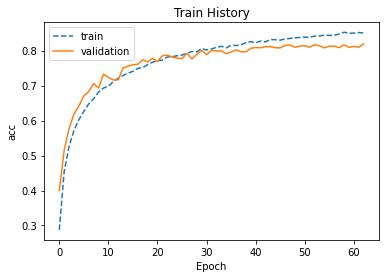

In [ ]:
show_train_history(train_history,'acc','val_acc')

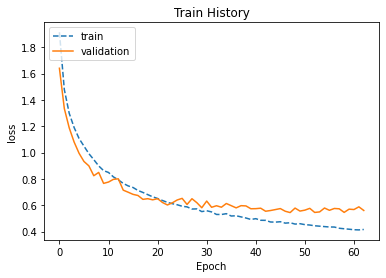

In [ ]:
show_train_history(train_history,'loss','val_loss')

# 評估模型準確率

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)

313/313 [==============================] - 2s 5ms/step - loss: 0.5762 - acc: 0.8178


In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.5761884450912476 test_acc= 0.817799985408783


# 載入最佳模型

In [ ]:
model.load_weights(filepath)

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)
scores[1]

313/313 [==============================] - 1s 4ms/step - loss: 0.5762 - acc: 0.8178


0.817799985408783

In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.5761884450912476 test_acc= 0.817799985408783


# 進行預測

In [ ]:
probability=model.predict(x_img_test_normalize)

In [ ]:
prediction=tf.argmax(probability, axis=-1).numpy()

In [ ]:
prediction[:10]

array([3, 8, 8, 0, 6, 6, 9, 6, 3, 1])

# 查看預測結果

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
      5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [ ]:
def plot_images_labels_prediction(
    images,labels,prediction,idx,num=10):
    fig = plt.gcf().set_size_inches(12, 12)    
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= str(idx)+',' +label_dict[labels[idx]]
        if len(prediction)>0:
            title+="=>"+label_dict[prediction[idx]]
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

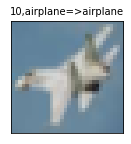

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=1)

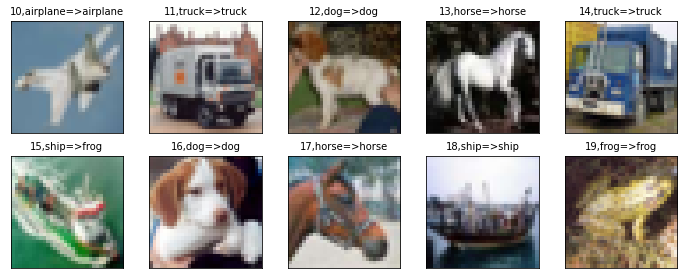

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=10)

# 查看預測機率

In [ ]:
def show_predicted_probability(
    images,labels,prediction,probability,idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]);plt.yticks([])
  plt.imshow(images[idx],cmap='binary')
  plt.show()
  print('label:',label_dict[labels[idx]],
     'predict:',label_dict[prediction[idx]]) 
  for i in range(10):
    print('%-10s Probability:%.9f'%(label_dict[i],probability[idx][i]))      

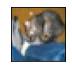

label: cat predict: cat
airplane   Probability:0.000411685
automobile Probability:0.000002841
bird       Probability:0.010458054
cat        Probability:0.782546341
deer       Probability:0.008207443
dog        Probability:0.139362082
frog       Probability:0.055195838
horse      Probability:0.003513108
ship       Probability:0.000296274
truck      Probability:0.000006383


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,0) 

# confusion matrix

In [ ]:
import pandas as pd

In [ ]:
pd.crosstab(y_label_test,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,818,12,37,14,11,3,10,14,52,29
1,8,906,2,3,1,1,12,4,13,50
2,38,1,715,32,61,57,72,12,7,5
3,15,3,46,639,45,136,75,28,4,9
4,8,1,42,39,797,19,57,31,3,3
5,7,2,32,119,38,731,26,39,2,4
6,4,0,20,29,12,14,912,4,3,2
7,7,1,15,28,36,26,6,874,3,4
8,35,18,12,12,4,3,7,2,893,14


In [ ]:
df = pd.DataFrame({'label':y_label_test, 'predict':prediction})

In [ ]:
df[:5]

,label,predict
0,3,3
1,8,8
2,8,8
3,0,0
4,6,6


In [ ]:
df[(df.label==5)&(df.predict==3)]

,label,predict
158,5,3
200,5,3
239,5,3
262,5,3
474,5,3
...,...,...
9380,5,3
9414,5,3
9551,5,3
9654,5,3


# 查看預測錯誤資料

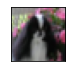

label: dog predict: dog
airplane   Probability:0.000043718
automobile Probability:0.000009596
bird       Probability:0.026771717
cat        Probability:0.200557947
deer       Probability:0.006214238
dog        Probability:0.691607058
frog       Probability:0.001110839
horse      Probability:0.072752006
ship       Probability:0.000093088
truck      Probability:0.000839771


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,42)

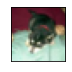

label: dog predict: frog
airplane   Probability:0.000479064
automobile Probability:0.000013342
bird       Probability:0.003469668
cat        Probability:0.136031315
deer       Probability:0.000574959
dog        Probability:0.098201141
frog       Probability:0.760113299
horse      Probability:0.000899681
ship       Probability:0.000002131
truck      Probability:0.000215392


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,128)